**Aufgabe 17:**

Implementieren Sie das implizite Euler Verfahren unter Verwendung des Newton-Verfahrens zur Lösung des nichtlinearen Gleichungssystems. Der Algorithmus soll als Input-Parameter einen Vektor von Stützstellen $t$, einen Startwert $y_0$, die rechte Seite und Ableitung der rechten Seite $f$ bzw. $\frac{\partial}{\partial t} f$ sowie eine geeignete Abbruchbedinung für das Newton Verfahren (Toleranz und/oder maximale Anzahl an Interationen) akzeptieren.

Testen Sie das Verfahren an folgenden Anfangswertproblemen: Sei $Y = (y_1, y_2)^T$ die Lösung des Anfangswertproblems

\begin{align} \tag{1}
    Y^\prime(t)
    =
    \begin{pmatrix}
        -2 &  1 \\
         1 & -2
    \end{pmatrix}
    Y(t)
    +
    \begin{pmatrix}
        2 \sin{t} \\
        2 (\cos{t} - \sin{t})
    \end{pmatrix},
    \quad
    t \geq 0,
    \quad
    Y(0)
    =
    \begin{pmatrix}
        2 \\
        3
    \end{pmatrix}.
\end{align}

Sei $Z = (z_1, z_2)^T$ die Lösung des Anfangswertproblems

\begin{align} \tag{2}
    Z^\prime(t)
    =
    \begin{pmatrix}
        -2   &  1 \\
         998 & -999
    \end{pmatrix}
    Z(t)
    +
    \begin{pmatrix}
        2 \sin{t} \\
        999 (\cos{t} - \sin{t})
    \end{pmatrix},
    \quad
    t \geq 0,
    \quad
    Z(0)
    =
    \begin{pmatrix}
        2 \\
        3
    \end{pmatrix}.
\end{align}

Vergleichen Sie dabei auch mit den Ergebnissen und Schrittweiten des eingebetteten Runge-Kutta Verfahren RK5(4) aus Aufgabe 15. Verwenden Sie dazu die Parameter $t \in [0, 10]$, $\rho = 0.7$, $\eta = 1.5$, $\text{tol} = 10^{-6}$, $h_{\text{min}} = 10^{-10}$.

In [178]:
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
from timeit import default_timer as timer

In [167]:
def newton(F, DF, x_0, tol = 1e-6, t_max = 1e16):

    """
        This function applies the Newton-Method
        (from Nannen, Numerik A, Algorithmus 7.12).

        F ....... We search for x such that F(x) = 0.
        x_0 ..... where the iteration starts
        tol ..... tolerance for accuracy of F(x)
        t_max ... maximum iterations for Newton-Method
    """

    x = [x_0]
    Delta_x = [np.linalg.solve(DF(x[0]), -F(x[0]))]
    x += [x[0] + Delta_x[0]]
    t = 0

    while True:

        t += 1
        Delta_x += [np.linalg.solve(DF(x[t]), -F(x[t]))]
        x += [x[t] + Delta_x[t]]

        q_t = np.linalg.norm(Delta_x[t]) / np.linalg.norm(Delta_x[t-1])

        if q_t >= 1:
            print("STOP: Newton-Verfahren konvergiert nicht.")
            return None

        if q_t / (1 - q_t) * np.linalg.norm(Delta_x[t]) <= tol or t > t_max:
            return x[t+1]

In [168]:
def implicit_euler(t, y_0, f, f_y, tol = 1e-6, counter_max = 1e3):

    """
        This function applies the implicit Euler-Method.

        t ............. time steps
        y_0 ........... initial value at t_0 for solution
        f_y ........... right hand side
        Df ............ derivative with respect to y of right hand side
        tol ........... tolerance for accuracy of F(x)
        counter_max ... maximum iterations for Newton-Method
    """

    # dimension of range of f
    n = len(y_0)

    # t = t_0, ..., t_N
    N = len(t) - 1

    # distance between time steps
    h = t[1::] - t[:-1:]

    # approximated solution
    y = [y_0]

    for ell in range(N):

        F_ell  = lambda y_new: y_new - (y[-1] + h[ell] * f(t[ell+1], y_new))
        DF_ell = lambda y_new: np.eye(n, n) - h[ell] * f_y(t[ell+1], y_new)

#         guess = y[-1]
        guess = y[-1] + h[ell] * f(t[ell], y[-1])

#         y_new = newton(F_ell, DF_ell, guess, tol)
        y_new = fsolve(F_ell, guess, xtol = tol)

#         print("Test ...", y_new == y[-1] + h[ell] * f(t[ell+1], y_new))
        y += [y_new]

    y = np.array(y).transpose()

    return y

In [159]:
def test_implicit_euler(f, f_y, y_0, name = "y"):

    T = 10
    dt = 0.01
    t = np.arange(0, T, dt)

    y = implicit_euler(t, y_0, f, f_y)

    plt.plot(t, y[0], label = "$" + name + "_1(t)$")
    plt.plot(t, y[1], label = "$" + name + "_2(t)$")

    plt.legend()
    plt.xlabel("$t$")

    plt.grid(linestyle = ":")
    plt.suptitle("Implicit Euler-Method")
    plt.show()

In [192]:
def practical_adaptive_algorithm(t_0, T, y_0, f, c, A, b_1, b_2, p, tau, h, h_min, lambda_, rho):

    """
        This function applies the Practical adaptive algorithm
        (from Nannen, Numerics of differential equations, Algorithm 2.35).

        t_0 ... lower bound of interval [t_0, T]
        T ..... upper bound of interval [t_0, T]
        y_0 ... initial value
        f ..... right hand side

        c, A, b_1 ... butcher tableau of           explicit runge-kutta one-step method of order p
        c, A, b_2 ... butcher tableau of auxiliary explicit runge-kutta one-step method of order p+1
        p ........... -

        tau ....... tolerance
        h ......... initial time-step size
        h_min ..... minimal time-step size
        lambda_ ... conformity factor
        rho ....... safety factor
    """

    m = len(c)

    t = [t_0]
    y = [y_0]
    h_array = [0]

    print("initiating practical adaptive algorithm ...", "\n")
    start = timer()

    print("current status ...", round(t[-1]/T * 100, 2), "%")
    print("current time .....", round(timer() - start), "sec")
    print("")
    stop = timer()

    while True:

        # status update each second
        if timer() - stop >= 1:
            print("current status ...", round(t[-1]/T * 100, 2), "%")
            print("passed time ......", round(timer() - start), "sec")
            print("")
            stop = timer()

        h = min(T - t[-1], max(h_min, h))

        k = np.zeros((m, 2))

        for i in range(m):
            k[i] = f(t[-1] + c[i] * h, y[-1] + h * (A[i][:i] @ k[:i]))

        F_1 = b_1 @ k
        F_2 = b_2 @ k

        H  = rho * (tau / (np.linalg.norm(F_1 - F_2)))**(1/p) * h

        if h <= H or h <= h_min:

            t += [t[-1] + h]
            h_array += [h]
            y += [y[-1] + h * F_2]

            if t[-1] < T:
                h = min(H, lambda_ * h)

        else:
            h = min(H, h / lambda_)

        if t[-1] >= T:

            t = np.array(t)
            h = np.array(h_array)
            y = np.array(y).transpose()

            return t, h, y

In [115]:
def test_practical_adaptive_algorithm(f, y_0, name = "y"):

    t_0 = 0
    T   = 10

    rho = 0.7
    eta = 1.5

    tau   = 1e-6
    h_min = 1e-10

    h = 1e-6

    # Butcher tableau - RK5(4)
    A  = np.array([[0,           0,          0,           0,        0,            0,        0   ],
                   [1    /5,     0,          0,           0,        0,            0,        0   ],
                   [3    /40,    9    /40,   0,           0,        0,            0,        0   ],
                   [44   /45,   -56   /15,   32   /9,     0,        0,            0,        0   ],
                   [19372/6561, -25360/2187, 64448/6561, -212/729,  0,            0,        0   ],
                   [9017 /3168, -355  /33,   46732/5247,  49 /176, -5103 /18656,  0,        0   ],
                   [35   /384,   0,          500  /1113,  125/192, -2187 /6784,   11 /84,   0   ]])
    b_1 = np.array([35   /384,   0,          500  /1113,  125/192, -2187 /6784,   11 /84,   0   ])
    b_2 = np.array([5179 /57600, 0,          7571 /16695, 393/640, -92097/339200, 187/2100, 1/40])
    c   = np.array([0,           1    /5,    1    /10,    4  /5,    8    /9,      1,        1   ])
    p   = 4

    t, h, y = practical_adaptive_algorithm(t_0, T, y_0, f, c, A, b_1, b_2, p, tau, h, h_min, eta, rho)

    # ---------------- #

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))

    ax1.plot(t, y[0], label = "$" + name + "_1(t)$")
    ax1.plot(t, y[1], label = "$" + name + "_2(t)$")

    ax1.legend()
    ax1.set_xlabel("$t$")

    ax1.grid(linestyle = ":")

    ax2.plot(t, h, '--', label = "Schrittweite", color = "black", linewidth = 1)
    ax2.set_xlabel("$t$")
    ax2.set_ylabel("Schrittweite ($h$)")
    ax2.grid(linestyle = ':')

    plt.suptitle("Practical adaptive algorithm")
    plt.show()

    # ---------------- #

    fig = plt.figure(figsize = (15, 5))

    plt.plot(t, y[0] / max(y[0]), label = "$" + name + "_1(t)$")
    plt.plot(t, y[1] / max(y[1]), label = "$" + name + "_2(t)$")
    plt.plot(t, h    / max(h),    '--', label = "Schrittweite", color = "black", linewidth = 1)

    plt.legend()
    plt.xlabel("$t$")
    plt.ylabel("Relation to $|| \cdot ||_\infty$")
    plt.grid(linestyle = ':')
    plt.show()

Test 1 ...


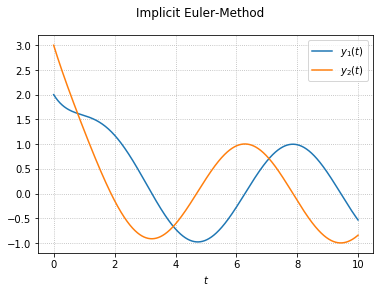

initiating practical adaptive algorithm ... 

current status ... 0.0 %
current time ..... 0 sec

current status ... 2.34 %
passed time ...... 1 sec

current status ... 4.27 %
passed time ...... 2 sec

current status ... 6.74 %
passed time ...... 3 sec

current status ... 8.9 %
passed time ...... 4 sec

current status ... 10.9 %
passed time ...... 5 sec

current status ... 13.53 %
passed time ...... 6 sec

current status ... 16.39 %
passed time ...... 7 sec

current status ... 20.31 %
passed time ...... 8 sec

current status ... 25.26 %
passed time ...... 9 sec

current status ... 28.53 %
passed time ...... 10 sec

current status ... 30.44 %
passed time ...... 11 sec

current status ... 32.97 %
passed time ...... 12 sec

current status ... 34.93 %
passed time ...... 13 sec

current status ... 36.45 %
passed time ...... 14 sec

current status ... 38.33 %
passed time ...... 15 sec

current status ... 40.49 %
passed time ...... 16 sec

current status ... 42.87 %
passed time ...... 17 sec



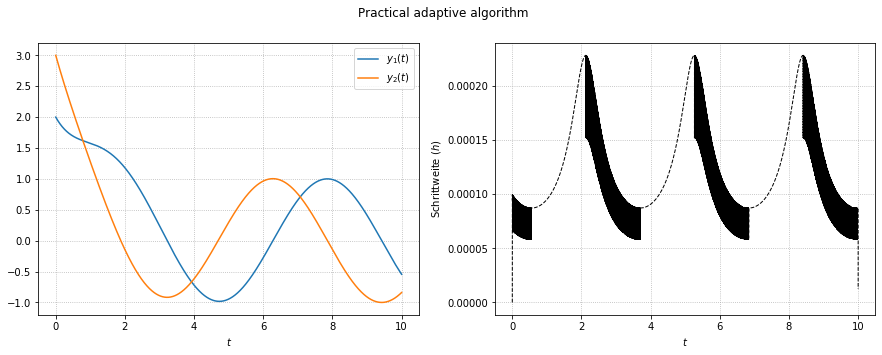

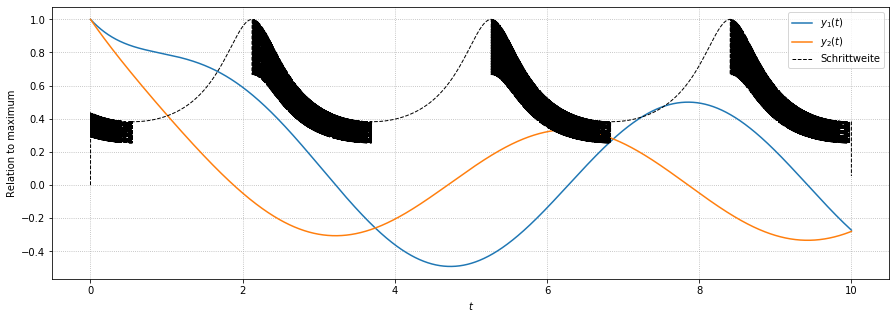

Test 2 ...


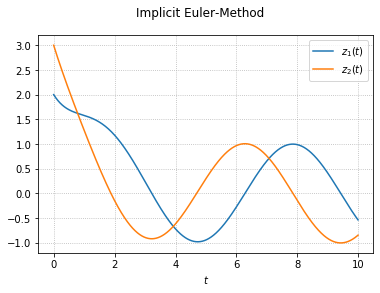

initiating practical adaptive algorithm ... 

current status ... 0.0 %
current time ..... 0 sec

current status ... 0.01 %
passed time ...... 1 sec

current status ... 0.01 %
passed time ...... 2 sec

current status ... 0.02 %
passed time ...... 3 sec

current status ... 0.03 %
passed time ...... 4 sec

current status ... 0.03 %
passed time ...... 5 sec

current status ... 0.04 %
passed time ...... 6 sec

current status ... 0.05 %
passed time ...... 7 sec

current status ... 0.05 %
passed time ...... 8 sec

current status ... 0.06 %
passed time ...... 9 sec

current status ... 0.06 %
passed time ...... 10 sec

current status ... 0.07 %
passed time ...... 11 sec

current status ... 0.08 %
passed time ...... 12 sec

current status ... 0.08 %
passed time ...... 13 sec

current status ... 0.09 %
passed time ...... 14 sec

current status ... 0.1 %
passed time ...... 15 sec

current status ... 0.11 %
passed time ...... 16 sec

current status ... 0.11 %
passed time ...... 17 sec

current stat

KeyboardInterrupt: 

In [193]:
# Test 1

def f(t, Y):
    A = np.array([[-2, 1], [1, -2]])
    b = np.array([2 * np.sin(t), 2 * (np.cos(t) - np.sin(t))])
    return A @ Y + b

def f_Y(t, Y):
    A = np.array([[-2, 1], [1, -2]])
    return A

Y_0 = np.array([2, 3])

print("Test 1 ...")
test_implicit_euler(f, f_y, Y_0)
test_practical_adaptive_algorithm(f, Y_0)

# Test 2

def f(t, Z):
    A = np.array([[-2, 1], [998, -999]])
    b = np.array([2 * np.sin(t), 999 * (np.cos(t) - np.sin(t))])
    return A @ Z + b

def f_Z(t, Z):
    A = np.array([[-2, 1], [998, -999]])
    return A

Z_0 = np.array([2, 3])

print("Test 2 ...")
test_implicit_euler(f, f_Y, Z_0, name = "z")
test_practical_adaptive_algorithm(f, Z_0, name = "z")